In [19]:
#%load_ext zipline

In [1]:
import zipline
from zipline.api import order_target_percent, record, symbol, set_benchmark, get_open_orders
from zipline.data.bundles import register
from zipline.data.bundles.csvdir import csvdir_equities

from trading_calendars import get_calendar

from zipline.api import get_datetime, order_percent

from datetime import datetime
import pytz
import pandas as pd
import numpy as np
import pyfolio as pf
import seaborn as sns
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials

In [2]:
#Check available bundles
!zipline bundles

AWP-bundle 2020-05-04 08:57:59.735378
AWP-bundle 2020-05-04 08:56:54.052068
AWP-bundle 2020-05-04 08:55:33.298094
AWP-bundle 2020-05-03 18:20:00.696303
AWP-bundle 2020-05-03 17:38:57.821867
BRK-bundle 2020-05-17 11:41:09.511527
csvdir <no ingestions>
quandl <no ingestions>
quantopian-quandl <no ingestions>
yahoo_csv_bundle1 2020-04-25 15:59:07.765565
yahoo_csv_bundle1 2020-04-25 14:54:33.556372
yahoo_csv_bundle1 2020-04-25 14:53:48.415615
yahoo_csv_bundle1 2020-04-25 14:21:09.498439
yahoo_csv_bundle1 2020-04-24 18:58:07.366369
yahoo_csv_bundle1 2020-04-24 14:51:35.470641
yahoo_csv_bundle2 <no ingestions>
yahoo_csv_bundle_allweather 2020-04-29 15:14:37.412112
yahoo_csv_bundle_allweather 2020-04-29 14:44:02.142447
yahoo_csv_bundle_allweather 2020-04-29 14:38:35.946527
yahoo_csv_bundle_allweather 2020-04-29 14:35:44.021084
yahoo_csv_bundle_allweather 2020-04-29 14:32:15.192010
yahoo_csv_bundle_allweather_as <no ingestions>
yahoo_csv_bundle_allweather_l <no ingestions>
yahoo_csv_bundle_all

In [22]:
def initialize(context):
    set_benchmark(symbol('SPY'))
    context.stock = symbol('SPY')
    context.long_bond = symbol('TLT')
    context.mid_bond = symbol('IEI')
    context.gold = symbol('GLD')
    context.commodity = symbol('GSG')
    
    context.stock_position = 0.30
    context.long_bond_position = 0.40
    context.mid_bond_position = 0.15
    context.gold_position = 0.075
    context.commodity_position = 0.075
    
    #context.stock_position = 1
    #context.long_bond_position = 0
    #context.mid_bond_position = 0
    #context.gold_position = 0
    #context.commodity_position = 0
    
    context.rebalance_inteval = 365
    context.rebalance_date = 0
 
    context.fired = False

In [23]:
def rebalance(context, data):
    values = context.portfolio.portfolio_value
    
    order_percent(context.stock,0)
    order_percent(context.long_bond,0)
    order_percent(context.mid_bond,0)
    order_percent(context.gold,0)
    order_percent(context.commodity,0)
    
    order_target_percent(context.stock,context.stock_position)
    order_target_percent(context.long_bond, context.long_bond_position)
    order_target_percent(context.mid_bond, context.mid_bond_position)
    order_target_percent(context.gold,context.gold_position)
    order_target_percent(context.commodity, context.commodity_position)

In [24]:
def handle_data(context, data):
    if not context.fired:
        order_target_percent(context.stock,context.stock_position)
        order_target_percent(context.long_bond, context.long_bond_position)
        order_target_percent(context.mid_bond, context.mid_bond_position)
        order_target_percent(context.gold, context.gold_position)
        order_target_percent(context.commodity, context.commodity_position)
        context.rebalance_date = get_datetime()
        print("build portfolio at " + str(context.rebalance_date))
        context.fired = True
    else:
        now = get_datetime()
        if (now.year > context.rebalance_date.year):
            print("new year arrivied:" + str(now))
            
            context.rebalance_date = now
            rebalance(context, data)

In [25]:
#%zipline --start 2007-1-3 --end 2020-4-29 --capital-base 10000 --bundle AWP-bundle -o buy_and_hold.pkl --trading-calendar NYSE

In [28]:
start = datetime(2015, 1, 20, 0, 0, 0, 0, pytz.utc)
end = datetime(2020, 4, 24, 0, 0, 0, 0, pytz.utc)
#start = datetime(2017, 1, 1, 0, 0, 0, 0, pytz.utc)
#end = datetime(2020, 2, 26, 0, 0, 0, 0, pytz.utc)

perf = zipline.run_algorithm(start=start,
                end=end,
                initialize=initialize,
                capital_base=10000,
                bundle='BRK-bundle',
                handle_data=handle_data)

build portfolio at 2015-01-20 21:00:00+00:00
new year arrivied:2016-01-04 21:00:00+00:00
new year arrivied:2017-01-03 21:00:00+00:00
new year arrivied:2018-01-02 21:00:00+00:00
new year arrivied:2019-01-02 21:00:00+00:00
new year arrivied:2020-01-02 21:00:00+00:00


Start date,2015-01-20
End date,2020-04-24
Total months,63
,Backtest
Annual return,3.9%
Cumulative returns,22.4%
Annual volatility,6.9%
Sharpe ratio,0.59
Calmar ratio,0.29
Stability,0.74
Max drawdown,-13.7%


/Users/cedriss/miniconda3/envs/env_zipline/envs/env_zipline_remote/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.69,2020-03-06,2020-03-18,NaT,NaN
1,9.78,2015-02-02,2016-01-11,2016-06-29,368
2,8.48,2018-01-26,2018-12-24,2019-04-10,314
3,7.79,2016-07-08,2016-12-01,2017-11-03,346
4,2.94,2019-09-04,2019-09-13,2019-12-26,82


Stress Events,mean,min,max
Fall2015,-0.08%,-1.45%,1.06%
New Normal,0.02%,-4.40%,2.50%


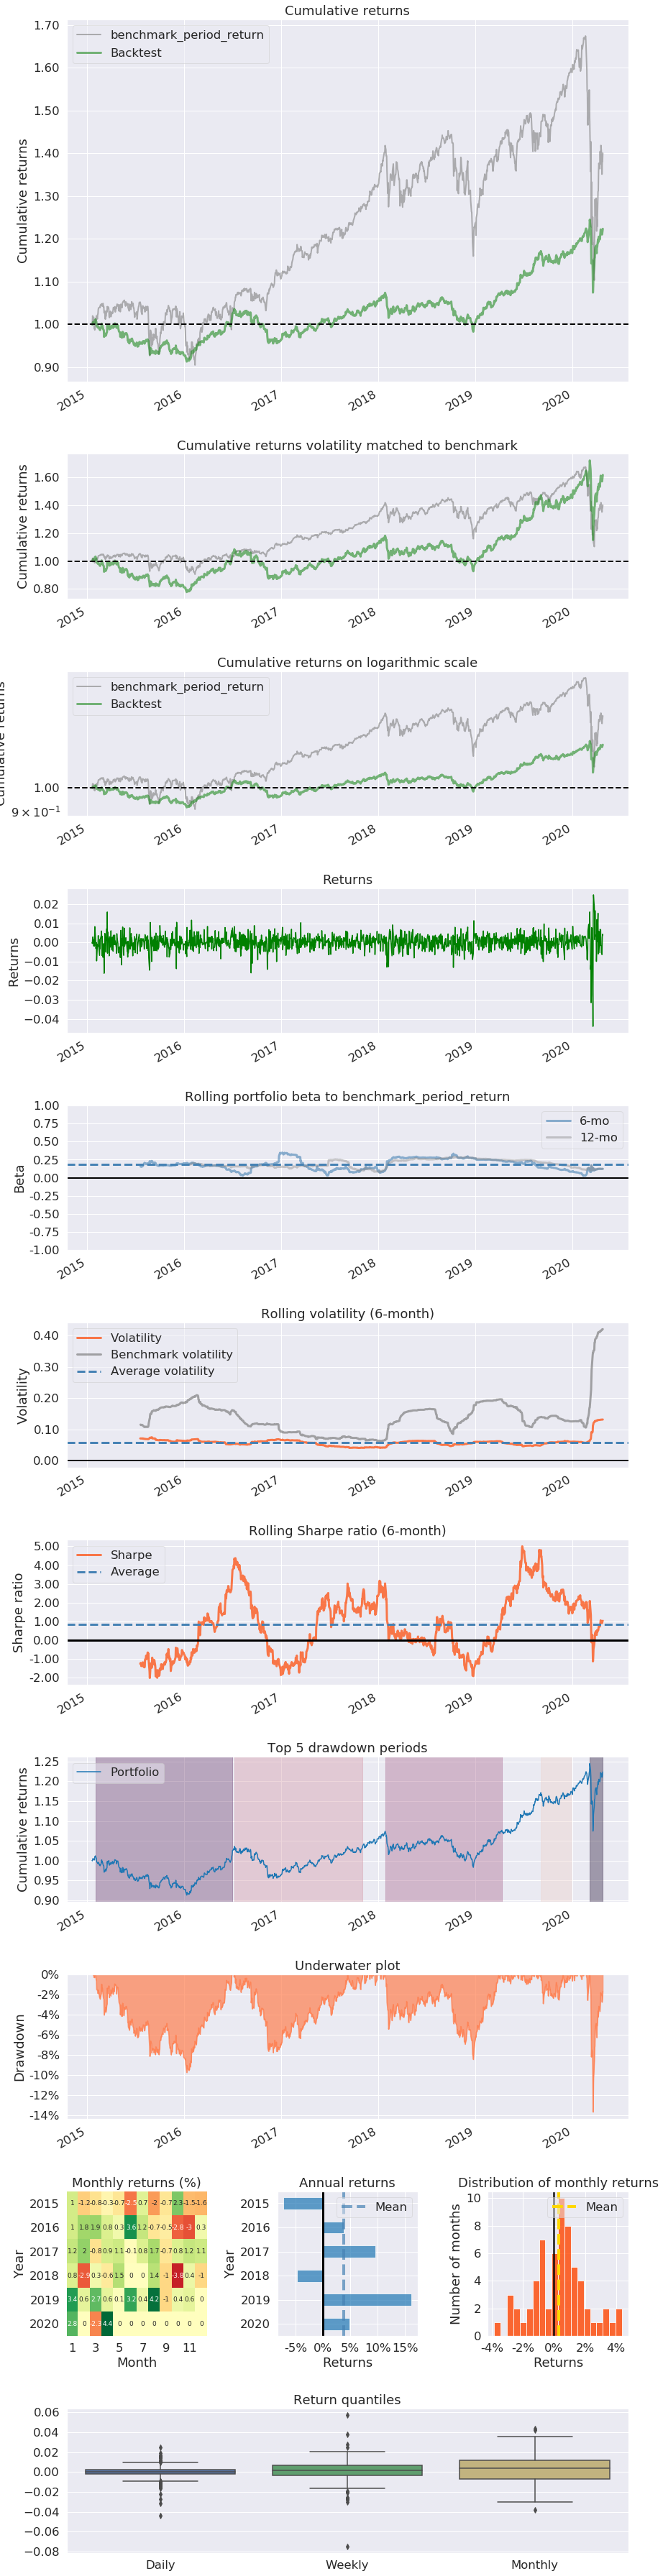

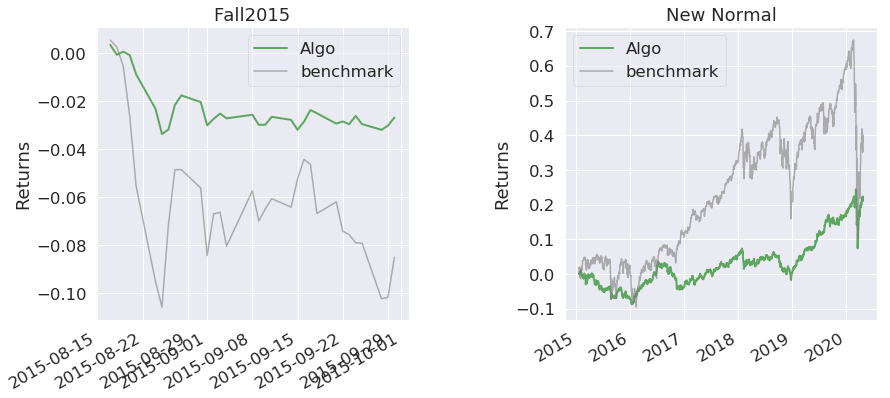

In [29]:
# Extract algo returns and benchmark returns
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf['benchmark_period_return']

# Convert benchmark returns to daily returns
daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

# Create tear sheet
#pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns)
pf.create_full_tear_sheet(returns,benchmark_rets=daily_benchmark_returns)